In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2022, 12, 31)

In [3]:
def read_yahoo_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Adj Close"]]
    df["Date"] = pd.to_datetime(df["Date"])

    column_name = ".".join(os.path.basename(filepath).split(".")[:-1])

    df.rename(columns = {"Adj Close": column_name}, inplace = True)
    return df

def read_yahoo_folder(folderpath, start, end):
    df = pd.DataFrame({'Date': pd.date_range(start, end, freq = 'D')})

    with os.scandir(folderpath) as entries:
        for entry in entries:
            df = df.merge(read_yahoo_csv(entry), on = "Date", how = "left")

    df.set_index("Date", inplace = True)
    return df

Data downloaded manually from the Yahoo Finance website.

In [4]:
etf_df = read_yahoo_folder("data/etfs/", START_DATE, END_DATE)
exchange_rates_df = read_yahoo_folder("data/exchange-rates/", START_DATE, END_DATE)

<AxesSubplot: xlabel='Date'>

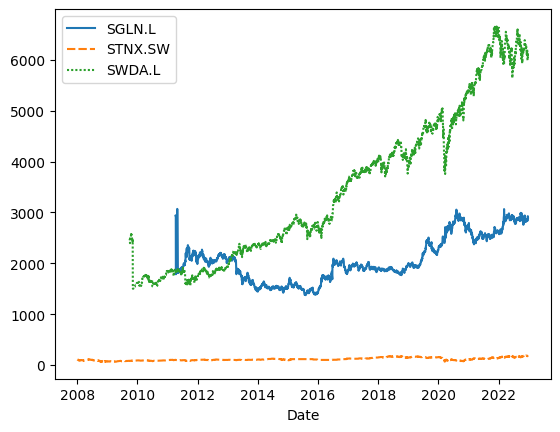

In [5]:
sns.lineplot(data = etf_df)

<AxesSubplot: xlabel='Date'>

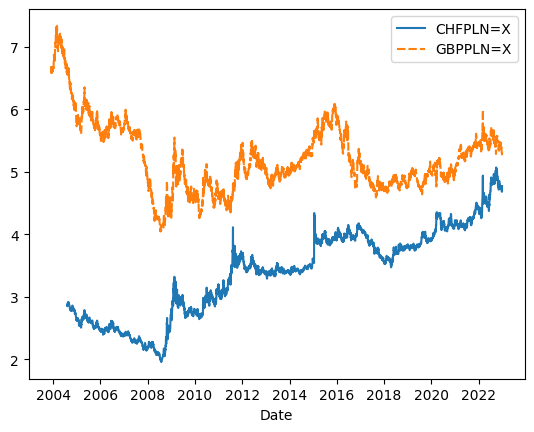

In [6]:
sns.lineplot(data = exchange_rates_df)

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions.

In [7]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
}

for column_name in etf_df.columns:
    etf_df[column_name] = etf_df[column_name] * exchange_rates_df[etf_currencies[column_name][0]] * etf_currencies[column_name][1]

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [8]:
etf_df.dropna(inplace = True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, let's write down the latest prices.

In [9]:
latest_prices = get_latest_prices(etf_df)

etf_df = etf_df.div(etf_df.iloc[0] / 100)

In [10]:
latest_prices

SGLN.L     152.883882
STNX.SW    854.922003
SWDA.L     319.144446
Name: 2022-12-23 00:00:00, dtype: float64

In [11]:
etf_df

,SGLN.L,STNX.SW,SWDA.L
Date,,,
2011-04-08,100.000000,100.000000,100.000000
2011-04-11,98.836062,99.067738,99.100117
2011-04-12,60.306065,96.246098,98.622015
2011-04-13,60.222064,97.994139,98.597552
2011-04-14,60.268648,97.280441,97.477276
...,...,...,...
2022-12-19,115.928443,272.838522,386.205558
2022-12-20,117.545770,272.223929,384.797486
2022-12-21,117.919639,277.056665,392.061568


[Text(0.5, 1.0, 'Portfolio Components History'), Text(0, 0.5, 'Value (PLN)')]

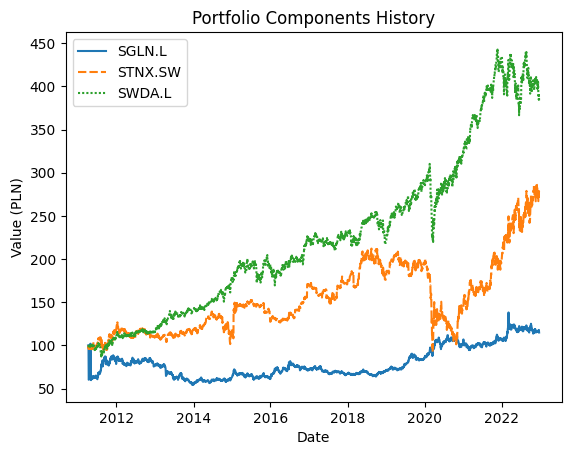

In [12]:
sns.lineplot(data = etf_df).set(title = 'Portfolio Components History', ylabel = 'Value (PLN)')

In [13]:
#Show the daily simple return
returns = etf_df.pct_change()
returns

,SGLN.L,STNX.SW,SWDA.L
Date,,,
2011-04-08,NaN,NaN,NaN
2011-04-11,-0.011639,-0.009323,-0.008999
2011-04-12,-0.389837,-0.028482,-0.004824
2011-04-13,-0.001393,0.018162,-0.000248
2011-04-14,0.000774,-0.007283,-0.011362
...,...,...,...
2022-12-19,0.000719,0.021518,-0.002203
2022-12-20,0.013951,-0.002253,-0.003646
2022-12-21,0.003181,0.017753,0.018878


In [14]:
#Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,SGLN.L,STNX.SW,SWDA.L
SGLN.L,0.101875,0.008613,0.010261
STNX.SW,0.008613,0.072660,0.020804
SWDA.L,0.010261,0.020804,0.032681


In [15]:
#Assign weights to the stocks
weights = np.array([.5, .25, .25])

In [16]:
#Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.0393715344994599

In [17]:
# Calculate the portfolio volatility (aka standard deviation)
port_volatility = np.sqrt(port_variance)
port_volatility

0.19842261589712978

In [18]:
# Calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.09654462311063904

In [19]:
#Show the expected annual return, volatility (aka risk), and variance

percent_var = str(round(port_variance, 2) * 100) + "%"
percent_vols = str(round(port_volatility, 2) * 100) + "%"
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + "%" 

print("Expected annual return: " + percent_ret)
print("Annual volatility (risk): " + percent_vols)
print("Annual variance: " + percent_var)

Expected annual return: 10.0%
Annual volatility (risk): 20.0%
Annual variance: 4.0%


In [20]:
# Portfolio optimisation

# Calculate the expected returns and the annualised sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(etf_df)
S = risk_models.sample_cov(etf_df)

# Optimize for max Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('SGLN.L', 0.0), ('STNX.SW', 0.03474), ('SWDA.L', 0.96526)])
Expected annual return: 12.5%
Annual volatility: 17.9%
Sharpe Ratio: 0.59


(0.12498408184148875, 0.17869750420452246, 0.5874960722525403)

In [24]:
# Get the discrete allocation of each share per stock
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

Discrete Allocation: {'STNX.SW': 2, 'SWDA.L': 151}
Funds Remaining: 99.34 zł
